In [19]:
# The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centered and occupies about the same amount of space in each image. 
#The task is to categorize each face based on the emotion shown in the facial expression in to one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).
#train.csv contains two columns, "emotion" and "pixels". The "emotion" column contains a numeric code ranging from 0 to 6, inclusive, for the emotion that is present in the image. 
#The "pixels" column contains a string surrounded in quotes for each image. The contents of this string a space-separated pixel values in row major order. test.csv contains only 
#the "pixels" column and your task is to predict the emotion column.
#The training set consists of 28,709 examples. 
#The public test set used for the leaderboard consists of 3,589 examples. The final test set, which was used to determine the winner of the competition, consists of another 3,589 examples.
#This dataset was prepared by Pierre-Luc Carrier and Aaron Courville, as part of an ongoing research project. They have graciously provided the workshop organizers with a preliminary version of their dataset to use for this contest.
# Download Data from:
# https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data

In [20]:
from __future__ import print_function, division
from builtins import range
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
import tensorflow as tf

In [21]:
def getData(balance_ones=True, Ntest=1000):
    # images are 48x48 = 2304 size vectors
    print("Getting the image data...")
    Y = []
    X = []
    first = True #Skip the headers 
    for line in open('fer2013/fer2013.csv'):
        if first:
            first = False
        else:
            row = line.split(',')
            Y.append(int(row[0]))
            X.append([int(p) for p in row[1].split()])

    X, Y = np.array(X) / 255.0, np.array(Y) # turn into numpy arrays and normalize

    # shuffle and split
    X, Y = shuffle(X, Y)
    Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest]
    Xvalid, Yvalid = X[-Ntest:], Y[-Ntest:]

    if balance_ones:
        # balance the 1st class
        X0, Y0 = Xtrain[Ytrain!=1, :], Ytrain[Ytrain!=1]
        X1 = Xtrain[Ytrain==1, :]
        X1 = np.repeat(X1, 9, axis=0) # Balance class 1 by repeating 9 times
        Xtrain = np.vstack([X0, X1])
        Ytrain = np.concatenate((Y0, [1]*len(X1)))

    return Xtrain, Ytrain, Xvalid, Yvalid

def init_weight_and_bias(M1, M2):
    # weight Mtrix is randomized initialy to a guasian normal
    W = np.random.randn(M1, M2) / np.sqrt(M1)
    b = np.zeros(M2)
    return W.astype(np.float32), b.astype(np.float32)
#Turns an N*1 Vector of targets into a indicator matrix
def y2indicator(y):
    N = len(y)
    K = len(set(y))
    ind = np.zeros((N, K))
    for i in range(N):
        ind[i, y[i]] = 1
    return ind
# Error Rate between Targets and predictions
def error_rate(targets, predictions):
    return np.mean(targets != predictions)

In [22]:
label_map = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'surprise', 'Neutral']

In [23]:
X, Y, Xvalid, Yvalid = getData(balance_ones=False)

Getting the image data...


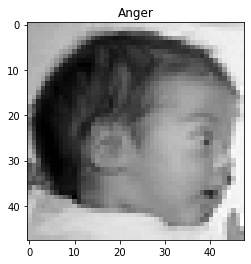

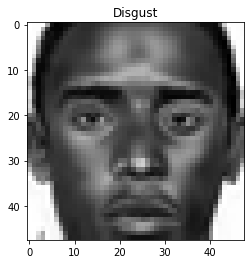

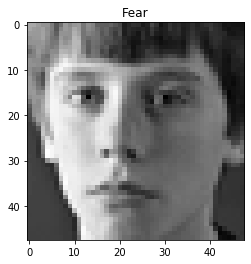

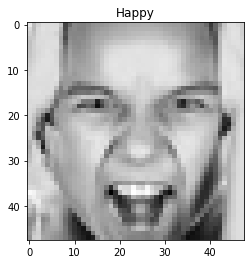

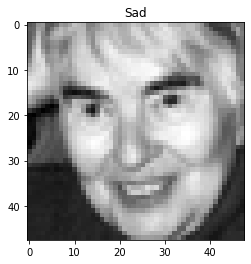

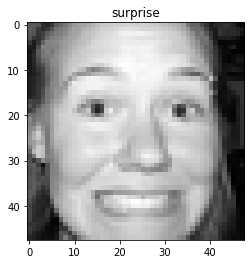

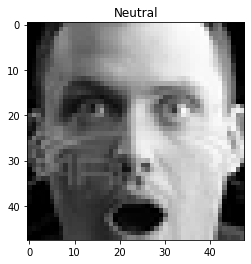

Quit? Enter Y: 
Y


In [24]:
# just showing some samples here
while True:
    for i in range(7):
        x = X[Y == i]
        y = Y[Y == i]
        N = len(Y)
        j = np.random.choice(N)
        plt.imshow(X[j].reshape(48,48), cmap = 'gray')
        plt.title(label_map[y[i]])
        plt.show()
    prompt = input('Quit? Enter Y: \n')
    if prompt == 'Y':
        break

In [31]:
class HiddenLayer(object):
    def __init__(self, M1, M2, id):
        self.id = id
        self.M1 = M1
        self.M2 = M2
        W,b = init_weight_and_bias(M1, M2)
        self.W = tf.Variable(W.astype(np.float32))
        self.b = tf.Variable(b.astype(np.float32))
        self.params = [self.W, self.b]
        
    def forward(self, X):
        return tf.nn.relu(tf.matmul(X, self.W) + self.b)
    
class ANN(object):
    def __init__(self, hidden_layer_sizes):
        self.hidden_layer_sizes = hidden_layer_sizes
        
    def fit(self, X, Y, Xvalid, Yvalid, learning_rate=1e-2, mu=0.99, decay=0.999, reg=1e-3, epochs=10, batch_sz=100, show_fig=False):
        K = len(set(Y))
        # make a validation set
        X, Y = shuffle(X, Y)
        X = X.astype(np.float32)
        Y = y2indicator(Y).astype(np.float32)

        # for calculating error rate
        Yvalid_flat = Yvalid
        Yvalid = y2indicator(Yvalid).astype(np.float32)
        
        # initialize hidden layers
        N, D = X.shape
        self.hidden_layers = []
        M1 = D
        count = 0
        for M2 in self.hidden_layer_sizes:
            h = HiddenLayer(M1, M2, count)
            self.hidden_layers.append(h)
            M1 = M2
            count += 1
        W, b = init_weight_and_bias(M1, K)
        self.W = tf.Variable(W.astype(np.float32))
        self.b = tf.Variable(b.astype(np.float32))

        # collect params for later use
        self.params = [self.W, self.b]
        for h in self.hidden_layers:
            self.params += h.params

        tfX = tf.placeholder(tf.float32, shape=(None, D), name='X')
        tfT = tf.placeholder(tf.float32, shape=(None, K), name='T')
        act = self.forward(tfX)
        rcost = reg*sum([tf.nn.l2_loss(p) for p in self.params])
        cost = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(
                logits=act,
                labels=tfT
            )
        ) + rcost
        prediction = self.predict(tfX)
        train_op = tf.train.RMSPropOptimizer(learning_rate, decay=decay, momentum=mu).minimize(cost)

        n_batches = N // batch_sz
        costs = []
        init = tf.global_variables_initializer()
        with tf.Session() as session:
            session.run(init)
            for i in range(epochs):
                X, Y = shuffle(X, Y)
                for j in range(n_batches):
                    Xbatch = X[j*batch_sz:(j*batch_sz+batch_sz)]
                    Ybatch = Y[j*batch_sz:(j*batch_sz+batch_sz)]

                    session.run(train_op, feed_dict={tfX: Xbatch, tfT: Ybatch})

                    if j % 20 == 0:
                        c = session.run(cost, feed_dict={tfX: Xvalid, tfT: Yvalid})
                        costs.append(c)

                        p = session.run(prediction, feed_dict={tfX: Xvalid, tfT: Yvalid})
                        e = error_rate(Yvalid_flat, p)
                        print("i:", i, "j:", j, "nb:", n_batches, "cost:", c, "error rate:", e)
        
        if show_fig:
            plt.plot(costs)
            plt.show()
            
    def forward(self, X):
        Z = X
        for h in self.hidden_layers:
            Z = h.forward(Z)
        return tf.matmul(Z, self.W) + self.b

    def predict(self, X):
        act = self.forward(X)
        return tf.argmax(act, 1)

Getting the image data...
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
i: 0 j: 0 nb: 391 cost: 3.6730504 error rate: 0.767
i: 0 j: 20 nb: 391 cost: 3.713992 error rate: 0.763
i: 0 j: 40 nb: 391 cost: 3.661158 error rate: 0.804
i: 0 j: 60 nb: 391 cost: 3.557407 error rate: 0.746
i: 0 j: 80 nb: 391 cost: 3.5502303 error rate: 0.739
i: 0 j: 100 nb: 391 cost: 3.4840412 error rate: 0.724
i: 0 j: 120 nb: 391 cost: 3.482608 error rate: 0.772
i: 0 j: 140 nb: 391 cost: 3.410163 error rate: 0.733
i: 0 j: 160 nb: 391 cost: 3.331704 error rate: 0.761
i: 0 j: 180 nb: 391 cost: 3.2748747 error rate: 0.721
i: 0 j: 200 nb: 391 cost: 3.2933064 error rate: 0.726
i: 0 j: 220 nb: 391 cost: 3.216033 error rate: 0.771
i: 0 j: 240 nb: 391 cost: 3.10

i: 6 j: 380 nb: 391 cost: 1.8891304 error rate: 0.761
i: 7 j: 0 nb: 391 cost: 1.9151723 error rate: 0.761
i: 7 j: 20 nb: 391 cost: 1.9477938 error rate: 0.761
i: 7 j: 40 nb: 391 cost: 1.9001609 error rate: 0.761
i: 7 j: 60 nb: 391 cost: 1.8841575 error rate: 0.761
i: 7 j: 80 nb: 391 cost: 1.8993156 error rate: 0.761
i: 7 j: 100 nb: 391 cost: 1.9174299 error rate: 0.761
i: 7 j: 120 nb: 391 cost: 1.9164643 error rate: 0.761
i: 7 j: 140 nb: 391 cost: 1.9066976 error rate: 0.761
i: 7 j: 160 nb: 391 cost: 1.9202274 error rate: 0.761
i: 7 j: 180 nb: 391 cost: 1.902294 error rate: 0.761
i: 7 j: 200 nb: 391 cost: 1.8949789 error rate: 0.761
i: 7 j: 220 nb: 391 cost: 1.9075162 error rate: 0.761
i: 7 j: 240 nb: 391 cost: 1.9335974 error rate: 0.761
i: 7 j: 260 nb: 391 cost: 1.9171904 error rate: 0.761
i: 7 j: 280 nb: 391 cost: 1.907901 error rate: 0.761
i: 7 j: 300 nb: 391 cost: 1.908846 error rate: 0.761
i: 7 j: 320 nb: 391 cost: 1.9218093 error rate: 0.761
i: 7 j: 340 nb: 391 cost: 1.921616 er

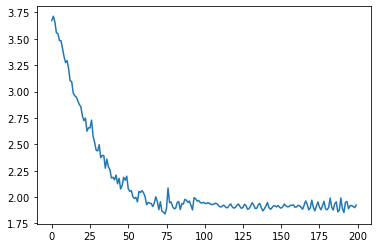

In [32]:
def main():
    Xtrain, Ytrain, Xvalid, Yvalid = getData()
    model = ANN([2000, 1000, 500])
    model.fit(Xtrain, Ytrain, Xvalid, Yvalid, show_fig=True)

if __name__ == '__main__':
    main()